# Algorithmic Trading 
## Part 2 - Reinforcement Learning
Project developed by Beatriz Alves Correia

Date: July 2023

In [277]:
# Import libraries
import yfinance as yf  # for dataset
import numpy as np  
import matplotlib.pyplot as plt  #plots

import pandas as pd
import numpy as np
import random
from collections import deque
import pickle # to save the model


### Data Loading same as with random forest approach

In [278]:
axp = yf.Ticker("AXP")
data = axp.history(start="2019-01-01", end="2023-09-30")
data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2019-01-02 00:00:00-05:00,86.886887,89.070386,86.757350,88.524513,4175400,0.00,0.0
2019-01-03 00:00:00-05:00,88.060004,88.422314,86.610765,86.796562,4776600,0.39,0.0
2019-01-04 00:00:00-05:00,88.598835,91.367254,88.162204,90.707664,4637200,0.00,0.0
2019-01-07 00:00:00-05:00,90.828426,91.896778,90.131675,91.200027,3289000,0.00,0.0
2019-01-08 00:00:00-05:00,91.683096,92.454161,90.596160,91.645935,3227200,0.00,0.0


### Add Daily Returns column to the dataset

In [279]:
# Calculate daily returns
data['Daily Returns'] = data['Close'].pct_change()
data['Daily Returns']

Date
2019-01-02 00:00:00-05:00         NaN
2019-01-03 00:00:00-05:00   -0.019519
2019-01-04 00:00:00-05:00    0.045061
2019-01-07 00:00:00-05:00    0.005428
2019-01-08 00:00:00-05:00    0.004889
                               ...   
2023-09-25 00:00:00-04:00    0.000980
2023-09-26 00:00:00-04:00   -0.013770
2023-09-27 00:00:00-04:00   -0.008073
2023-09-28 00:00:00-04:00    0.002201
2023-09-29 00:00:00-04:00   -0.006923
Name: Daily Returns, Length: 1195, dtype: float64

### Add Cumulative Returns column to the dataset

In [280]:
# Calculate the cumulative returns
cumulative_return = (1 + data['Daily Returns']).cumprod() - 1
data['Cumulative Returns'] = cumulative_return

# drop the na created with the calculation
data['Cumulative Returns'].dropna()
cumulative_return[-1]

C:\Users\beatr\AppData\Local\Temp\ipykernel_232464\1102244886.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cumulative_return[-1]


0.6678274786403777

### Check missing data

In [281]:
# check missing values
missing_values = data.isnull().sum()
missing_values

Open                  0
High                  0
Low                   0
Close                 0
Volume                0
Dividends             0
Stock Splits          0
Daily Returns         1
Cumulative Returns    1
dtype: int64

### Drop the missing data

In [282]:
# drop missing values created 
data = data.dropna()

### Add lag columns to the dataset
With the following function its possible to add the desired number of lags to the dataset in order to incorporate historical context to the model which can help the agent understand trends ans patterns in the market.
In this case we add 10 laggs do the dataset.

In [283]:
def add_lagged_features(data, num_lags=10):
    for lag in range(1, num_lags + 1):
        data[f'Lag_{lag}'] = data['Close'].shift(lag)
    data.dropna(inplace=True)  # Drop rows with NaN values caused by shifting
    return data

In [284]:
# Add lagged features
data = add_lagged_features(data)

### Computing Technical Indicators
The following code creates a trading strategy based on several technical indicators which is used to generate buy, hold, sell signals for trading. 
Technical indicators are mathematical calculations based on the price, volume, or open interest of a security. They are used to predict future price movements. In this project, we compute three indicators: Relative Strength Index (RSI), Bollinger Bands, and Moving Averages.
- Relative Strength Index (RSI): The RSI is a momentum oscillator that measures the speed and change of price movements. It is used to identify overbought or oversold conditions in a market.
- Bollinger Bands: Bollinger Bands are a volatility indicator that consists of a middle band (a simple moving average) and two outer bands (standard deviations away from the middle band).
- Moving Averages: Moving averages smooth out price data to identify trends. We use two moving averages: a short-term moving average (50 days) and a long-term moving average (200 days).

In [285]:
# Define indicators and add them to the dataset
def compute_rsi(series, window):
    delta = series.diff(1)  # The difference between the current price and the previous price.
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean() # The average gain over a specified window.
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean() # The average loss over a specified window.
    rs = gain / loss # The relative strength, calculated as the ratio of average gain to average loss.
    rsi = 100 - (100 / (1 + rs)) # The RSI value, calculated as 100 - (100 / (1 + rs)).
    return rsi

def compute_bollinger_bands(series, window=20, num_std=2):
    rolling_mean = series.rolling(window=window).mean()  # The rolling mean of the price over the specified window.
    rolling_std = series.rolling(window=window).std()  # The rolling standard deviation of the price over the specified window.
    upper_band = rolling_mean + (rolling_std * num_std)  # The upper Bollinger Band
    lower_band = rolling_mean - (rolling_std * num_std)  # The lower Bollinger Band
    return upper_band, lower_band

The generate_signals function calculates trading signals based on technical indicators to guide buy and sell decisions. It first computes the short-term (50-day) and long-term (200-day) moving averages, the Relative Strength Index (RSI), and Bollinger Bands from the closing prices. The default signal is set to 'HOLD'. Buy signals are generated when the short-term moving average is above the long-term moving average, the RSI is below 40, and the closing price is below the lower Bollinger Band. Conversely, sell signals are generated when the short-term moving average is below the long-term moving average, the RSI is above 60, and the closing price is above the upper Bollinger Band. The function updates the signals in the dataset and creates lists of entry (buy) and exit (sell) points. Finally, it returns dictionaries mapping these points to 'BUY' and 'SELL' actions, respectively. This process helps identify optimal trading times based on market conditions.

In [286]:
# Generating signals based on the indicators created above

def generate_signals(data):
    data['Short_MA'] = data['Close'].rolling(window=50).mean()
    data['Long_MA'] = data['Close'].rolling(window=200).mean()
    data['RSI'] = compute_rsi(data['Close'], window=14)
    data['Bollinger_Upper'], data['Bollinger_Lower'] = compute_bollinger_bands(data['Close'])

    data['Signal'] = 'HOLD'  # Default signal is hold
    buy_signals = (data['Short_MA'] > data['Long_MA']) & (data['RSI'] < 40) & (data['Close'] < data['Bollinger_Lower'])
    sell_signals = (data['Short_MA'] < data['Long_MA']) & (data['RSI'] > 60) & (data['Close'] > data['Bollinger_Upper'])
    
    data.loc[buy_signals, 'Signal'] = 'BUY'
    data.loc[sell_signals, 'Signal'] = 'SELL'

    entry_points = data[data['Signal'] == 'BUY'].index.tolist()
    exit_points = data[data['Signal'] == 'SELL'].index.tolist()

    entry_actions = {date: 'BUY' for date in entry_points}
    exit_actions = {date: 'SELL' for date in exit_points}

    return entry_actions, exit_actions

 Discretizing the Closing Price Feature
 - Discretize the Closing Price: Categorize the closing price into different bins.
- Combine with Other Indicators: Use moving averages or Bollinger Bands to define states.

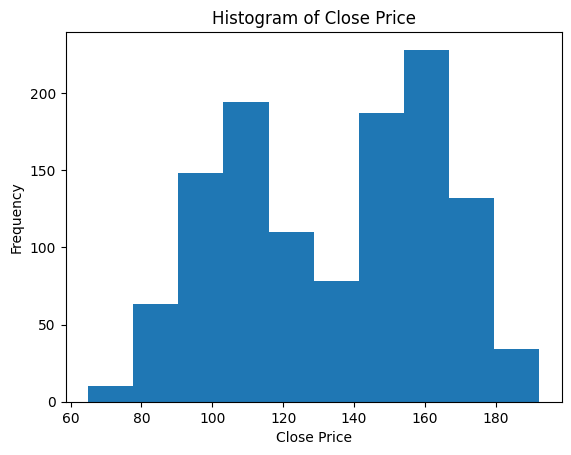

In [287]:
# histogram of close price
plt.hist(data['Close'])
plt.xlabel('Close Price')
plt.ylabel('Frequency')
plt.title('Histogram of Close Price')
plt.show()

In [327]:
def discretize_close_price(data):
    # Define bins for closing price based on the quantiles of the price distribution
    data['Close_Discretized'] = pd.qcut(data['Close'], 10, labels=False)  # Use qcut to create 6 bins of approximately equal size
    return data

# Q-Learning Approach
For this approach we need to define the following:
- Environment: AXP market (historical price data and indicators);
- State: Current market condition of the environment Close price;
- Action: 3 actions - Buy, Sell or Hold;
- Policy: Maximizing returns;
- Reward: Gains in the market;
- Agent: Learns to make trading decisions based on the environment state;
- Epsilon-greedy policy: Decision to choose action that has the highest expected reward.
- Q-Learning update rule: Q-value * learning rate + neagative decay term

In [328]:
# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)

In [329]:
# Define the Q-learning agent
class QLearningAgent:
    def __init__(self, num_states, num_actions, alpha=0.1, gamma=0.95, epsilon=0.2):
        self.num_states = num_states
        self.num_actions = num_actions  # sell, hold, buy (-1, 0, 1)
        self.alpha = alpha  # Learning rate
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon  # Exploration rate
        self.q_table = np.zeros((num_states, num_actions))

    def update_q_table(self, state, action, reward, next_state):
        max_q_value = np.max(self.q_table[next_state])
        self.q_table[state, action + 1] += self.alpha * (reward + self.gamma * max_q_value - self.q_table[state, action + 1])

    def choose_action(self, state):
        if np.random.uniform() < self.epsilon:
            return np.random.choice([-1, 0, 1])
        else:
            return np.argmax(self.q_table[state]) - 1

    def save_q_table(self, filename):
        with open(filename, 'wb') as file:
            pickle.dump(self.q_table, file)

    def load_q_table(self, filename):
        with open(filename, 'rb') as file:
            self.q_table = pickle.load(file)

In [1449]:
def trading_strategy(data, q_agent, entry_points, exit_points, initial_investment):
    num_states = 10  # Number of states based on discretized closing price
    num_actions = 3  # Number of actions (-1: sell, 0: hold, 1: buy)

    total_reward = 0  # Track total reward
    portfolio_value = [initial_investment]  # Track portfolio value
    trades = []  # Track executed trades
    shares = 0  # Initialize shares

    signals = []

    # Discretize the closing price
    data = discretize_close_price(data)

    # Iterate over each trading day
    for i in range(len(data) - 1):
        # Determine current state based on discretized closing price
        state = data['Close_Discretized'].iloc[i]

        # Check if an entry point exists for the current day
        if data.index[i] in entry_points or data.index[i] in exit_points:
            if data.index[i] in entry_points:
                action = 1  # Buy
            elif data.index[i] in exit_points:
                action = -1  # Sell

            if action == 1 and shares == 0:
                shares = portfolio_value[-1] / data['Close'].iloc[i]  # Buy as many shares as possible
                trades.append(('BUY', data.index[i], data['Close'].iloc[i], shares))
            elif action == -1 and shares > 0:
                portfolio_value[-1] = shares * data['Close'].iloc[i]  # Update portfolio value after selling
                trades.append(('SELL', data.index[i], data['Close'].iloc[i], shares))
                shares = 0

        # Calculate the reward based on the portfolio value change
        reward = (portfolio_value[-1] - portfolio_value[-2]) / portfolio_value[-2] if i > 0 else 0
        total_reward += reward

        # Choose the action using epsilon-greedy policy
        action = q_agent.choose_action(state)

        # Execute the action
        if action == 1 and shares == 0:  # Buy
            shares = portfolio_value[-1] / data['Close'].iloc[i]  # Buy as many shares as possible
            trades.append(('BUY', data.index[i], data['Close'].iloc[i], shares))
            signals.append(('BUY', i))  # Buy signal
        elif action == -1 and shares > 0:  # Sell
            portfolio_value[-1] = shares * data['Close'].iloc[i]  # Update portfolio value after selling
            trades.append(('SELL', data.index[i], data['Close'].iloc[i], shares))
            signals.append(('SELL', i))  # Sell signal
            shares = 0
        elif action == 0:  # Hold
            trades.append(('HOLD', data.index[i], data['Close'].iloc[i], shares))
            signals.append(('HOLD', i))  # Hold signal

        # Update the Q-table
        next_state = data['Close_Discretized'].iloc[i + 1]
        q_agent.update_q_table(state, action, reward, next_state)

        # Update the portfolio value
        if shares > 0:
            portfolio_value.append(shares * data['Close'].iloc[i + 1])
        else:
            portfolio_value.append(portfolio_value[-1])

    return total_reward, portfolio_value, trades, signals

In [1450]:
# Generate signals
entry_points, exit_points = generate_signals(data)

# Set initial investment
initial_investment = 100

# Create the Q-learning agent
q_agent = QLearningAgent(num_states=10, num_actions=3, alpha=0.1, gamma=0.95, epsilon=0.2)

# Apply the trading strategy
total_reward, portfolio_value, trades, signals = trading_strategy(data, q_agent, entry_points, exit_points, initial_investment)

In [358]:
def plot_signals(data, signals):
    plt.figure(figsize=(14, 7))
    plt.plot(data.index, data['Close'], label='Close Price', alpha=0.7)

    buy_signals = [i for signal, i in signals if signal == 'BUY']
    sell_signals = [i for signal, i in signals if signal == 'SELL']
    hold_signals = [i for signal, i in signals if signal == 'HOLD']

    plt.scatter(data.index[buy_signals], data['Close'].iloc[buy_signals], marker='^', color='g', label='Buy Signal', s=60, alpha=0.6, edgecolors='k')
    plt.scatter(data.index[sell_signals], data['Close'].iloc[sell_signals], marker='v', color='r', label='Sell Signal', s=60, alpha=0.6, edgecolors='k')
    plt.scatter(data.index[hold_signals], data['Close'].iloc[hold_signals], marker='o', color='y', label='Hold Signal', s=60, alpha=0.6, edgecolors='k')

    plt.title('Trading Signals on AXP Stock Data')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()


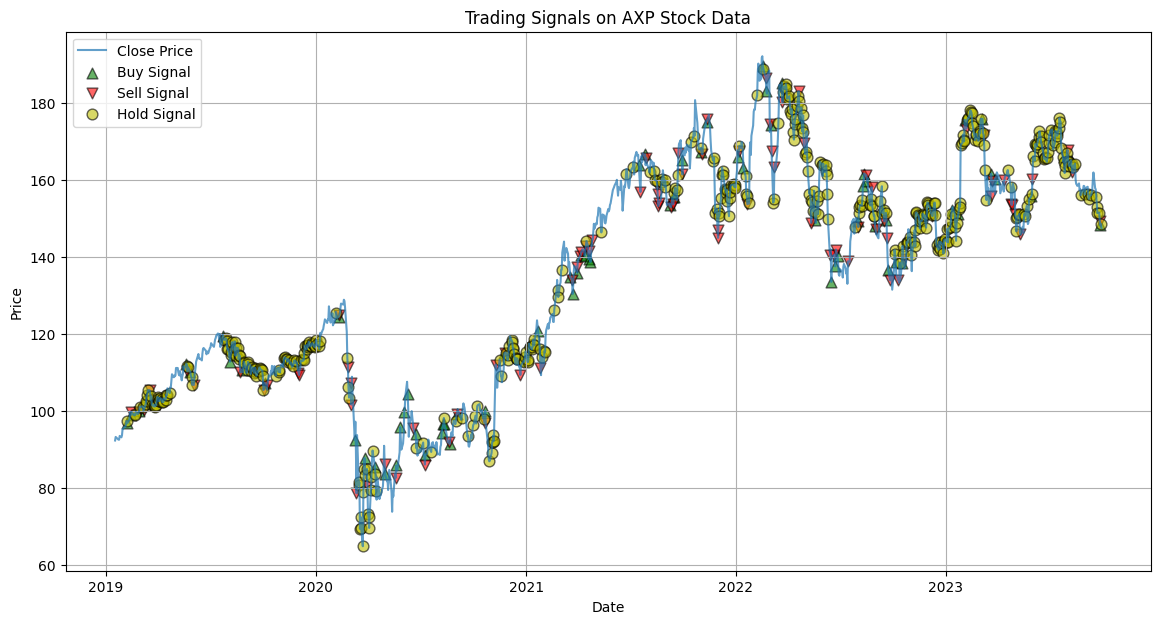

In [359]:
# Plot the signals
plot_signals(data, signals)

In [362]:
print("Total Reward:", total_reward)
print("Final Portfolio Value:", portfolio_value[-1])

Total Reward: -0.17005016571561457
Final Portfolio Value: 72.87760785694825


In [363]:
# Calculate the return on investment (ROI)
roi = (portfolio_value[-1] - initial_investment) / initial_investment * 100
print("Return on Investment (ROI): {:.2f}%".format(roi))

Return on Investment (ROI): -27.12%


### Hyperparameter tuning
We perform grid search to find the best hyperparameters for the Q-learning agent. The hyperparameters include the learning rate (alpha), discount factor (gamma), and exploration rate (epsilon).

In [336]:
from sklearn.model_selection import ParameterGrid

In [364]:
# Define a range of hyperparameters for grid search
param_grid = {
    'alpha': [0.1, 0.2, 0.3],
    'gamma': [0.9, 0.95, 0.99],
    'epsilon': [0.1, 0.2, 0.3]
}

In [365]:
# Function to evaluate a set of hyperparameters
def evaluate_params(params):
    q_agent = QLearningAgent(num_states=10, num_actions=3, alpha=params['alpha'], gamma=params['gamma'], epsilon=params['epsilon'])
    total_reward, portfolio_value, trades, signals = trading_strategy(data, q_agent, entry_points, exit_points, initial_investment)
    roi = (portfolio_value[-1] - initial_investment) / initial_investment * 100
    return roi

In [366]:
# Perform grid search
best_params = None
best_roi = -np.inf

for params in ParameterGrid(param_grid):
    roi = evaluate_params(params)
    print(f"Params: {params}, ROI: {roi:.2f}%")
    if roi > best_roi:
        best_roi = roi
        best_params = params

print(f"Best Params: {best_params}, Best ROI: {best_roi:.2f}%")

Params: {'alpha': 0.1, 'epsilon': 0.1, 'gamma': 0.9}, ROI: 157.98%
Params: {'alpha': 0.1, 'epsilon': 0.1, 'gamma': 0.95}, ROI: 49.82%
Params: {'alpha': 0.1, 'epsilon': 0.1, 'gamma': 0.99}, ROI: -8.78%
Params: {'alpha': 0.1, 'epsilon': 0.2, 'gamma': 0.9}, ROI: 141.38%
Params: {'alpha': 0.1, 'epsilon': 0.2, 'gamma': 0.95}, ROI: 48.77%
Params: {'alpha': 0.1, 'epsilon': 0.2, 'gamma': 0.99}, ROI: 13.00%
Params: {'alpha': 0.1, 'epsilon': 0.3, 'gamma': 0.9}, ROI: -4.82%
Params: {'alpha': 0.1, 'epsilon': 0.3, 'gamma': 0.95}, ROI: 3.69%
Params: {'alpha': 0.1, 'epsilon': 0.3, 'gamma': 0.99}, ROI: 28.29%
Params: {'alpha': 0.2, 'epsilon': 0.1, 'gamma': 0.9}, ROI: 63.65%
Params: {'alpha': 0.2, 'epsilon': 0.1, 'gamma': 0.95}, ROI: 11.26%
Params: {'alpha': 0.2, 'epsilon': 0.1, 'gamma': 0.99}, ROI: -27.43%
Params: {'alpha': 0.2, 'epsilon': 0.2, 'gamma': 0.9}, ROI: -6.04%
Params: {'alpha': 0.2, 'epsilon': 0.2, 'gamma': 0.95}, ROI: 31.62%
Params: {'alpha': 0.2, 'epsilon': 0.2, 'gamma': 0.99}, ROI: 18.79

In [1440]:
# Set initial investment
initial_investment = 100

# Create the Q-learning agent
q_agent = QLearningAgent(num_states=10, num_actions=3, alpha=0.1, gamma=0.99, epsilon=0.2)

# Apply the trading strategy
total_reward, portfolio_value, trades, signals = trading_strategy(data, q_agent, entry_points, exit_points, initial_investment)

Total Reward: 0.39600916381784035
Final Portfolio Value: 133.64416618977617


In [1446]:
print("Total Reward:", total_reward)
print("Final Portfolio Value:", portfolio_value[-1])

Total Reward: 1.6308385681258548
Final Portfolio Value: 429.84800378577995


### Save Q-Table

In [353]:
# Save the Q-table
q_agent.save_q_table('q_table.pkl')

# Load the Q-table (for future use)
#q_agent.load_q_table('q_table.pkl')

In [1447]:
q_agent.q_table

array([[0.08665325, 0.07718668, 0.09152038],
       [0.09438284, 0.08341324, 0.07832882],
       [0.09222797, 0.08939072, 0.10508228],
       [0.09719475, 0.11234317, 0.10110918],
       [0.10186338, 0.09672222, 0.10151259],
       [0.09881076, 0.09094896, 0.09574621],
       [0.09578134, 0.1049136 , 0.10398195],
       [0.10749709, 0.10581891, 0.10650298],
       [0.10813066, 0.10821013, 0.10720085],
       [0.11234028, 0.11035786, 0.11388597]])

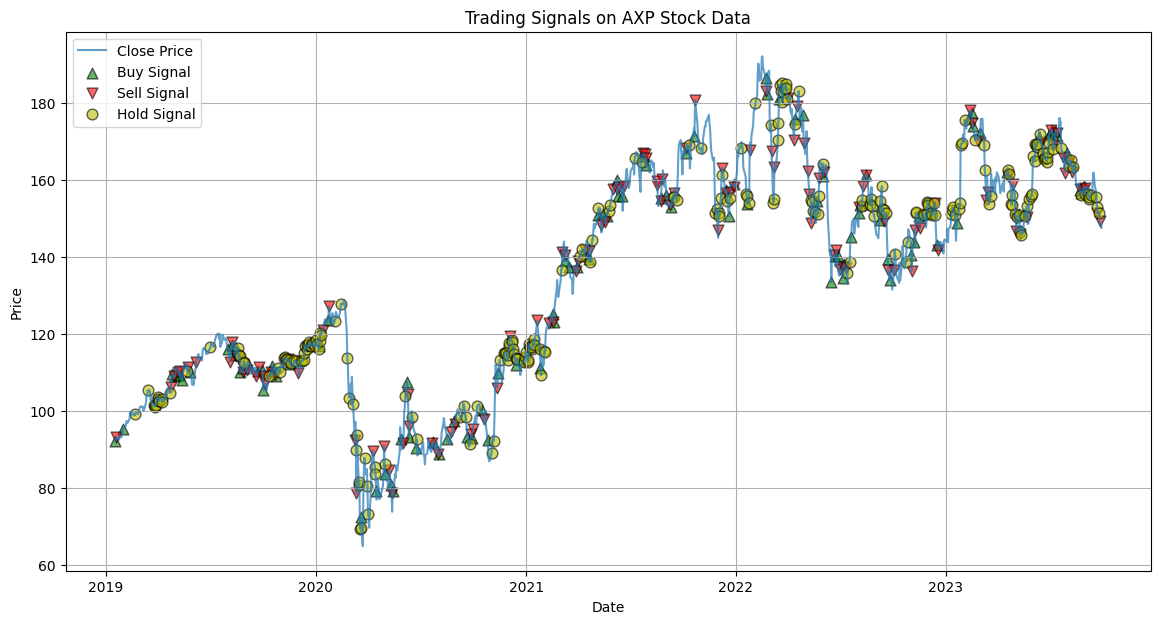

In [1448]:
# Plot the signals
plot_signals(data, signals)